# Dataset

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader,random_split,Dataset
import random
from pathlib import Path
from PIL import Image
from torch import nn
from torchvision import transforms,datasets
import os
import shutil


device  = 'cuda' if torch.cuda.is_available() else 'cpu'


try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary
try:
    from going_modular.going_modular import data_setup, engine
except:
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 26.99 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]
transforms= transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset
])

In [3]:
def organize_tomato_images(source_folder, destination_base_folder):
    # Create the destination folders in the specified writable location
    riped_folder = os.path.join(destination_base_folder, 'riped')
    unriped_folder = os.path.join(destination_base_folder, 'unriped')
    
    os.makedirs(riped_folder, exist_ok=True)
    os.makedirs(unriped_folder, exist_ok=True)

    # Iterate through the files in the source folder
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)

        # Check if it's a file (not a directory)
        if os.path.isfile(file_path):
            if filename.startswith('riped_tomato'):
                shutil.copy(file_path, os.path.join(riped_folder, filename))
            elif filename.startswith('unriped_tomato'):
                shutil.copy(file_path, os.path.join(unriped_folder, filename))

source_folder = '/kaggle/input/riped-and-unriped-tomato-dataset/Riped and Unriped Tomato Dataset/Images'
destination_base_folder = '/kaggle/working/data'
organize_tomato_images(source_folder, destination_base_folder)

In [4]:
dataset = datasets.ImageFolder(root='/kaggle/working/data', transform=transforms)

In [5]:
class_names = dataset.classes
print("Class names:", class_names)

Class names: ['riped', 'unriped']


In [6]:
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
def create_effnetb2():

    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

    #for i in model.features.parameters():
        #i.requires_grad =False

    model.to(device)
    model.classifier = nn.Sequential( nn.Dropout(p=0.3, inplace=True),nn.Linear(in_features=1408, out_features=len(class_names), bias=True))

    model.name = "effnetb2"

    return model

In [9]:
model = create_effnetb2()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 127MB/s]


In [10]:
summary(model=model,input_size=(1,3,224,224),col_names=['input_size','output_size','num_params','trainable'],col_width= 20,row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 2]               --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [12]:
device

'cuda'

In [13]:
from timeit import default_timer as timer
start_time = timer()

results =engine.train(model=model,
                      train_dataloader=train_loader,
                      test_dataloader=test_loader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=5,
                      device = device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} secounds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3790 | train_acc: 0.8438 | test_loss: 0.0886 | test_acc: 0.9688
Epoch: 2 | train_loss: 0.0967 | train_acc: 0.9534 | test_loss: 0.0209 | test_acc: 0.9844
Epoch: 3 | train_loss: 0.0393 | train_acc: 0.9812 | test_loss: 0.0144 | test_acc: 0.9844
Epoch: 4 | train_loss: 0.0295 | train_acc: 0.9875 | test_loss: 0.0053 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0759 | train_acc: 0.9875 | test_loss: 0.0145 | test_acc: 0.9844
[INFO] Total training time: 40.788 secounds


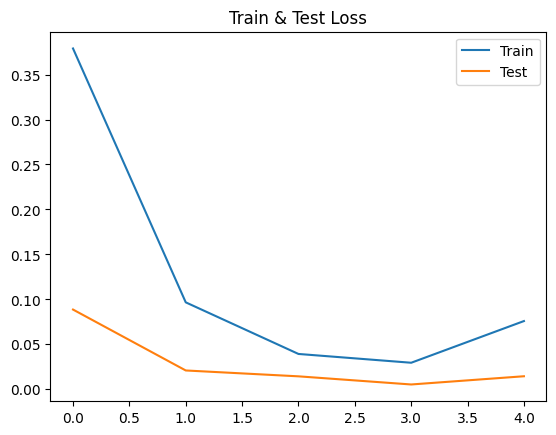

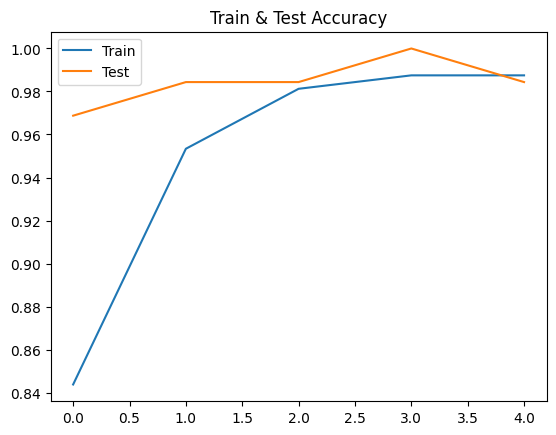

In [14]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.title("Train & Test Loss")
plt.legend(['Train','Test'])
plt.show()
plt.plot(results['train_acc'])
plt.plot(results['test_acc'])
plt.title("Train & Test Accuracy")
plt.legend(['Train','Test'])
plt.show()

In [15]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names,
                        image_size: [int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    image_transform = transform


    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

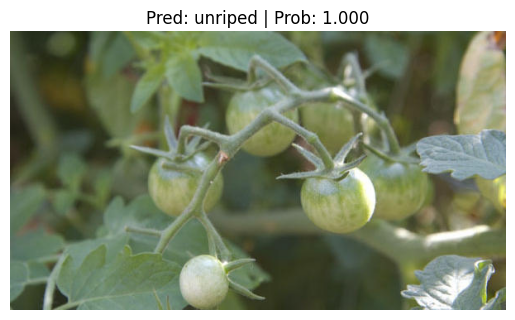

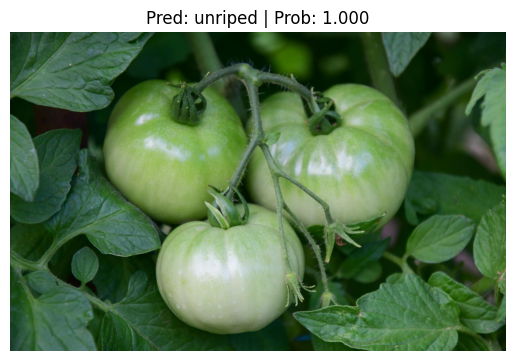

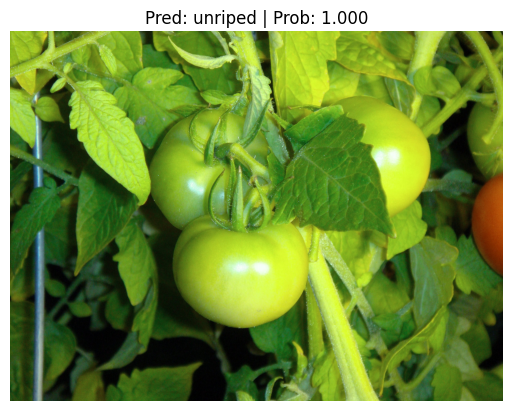

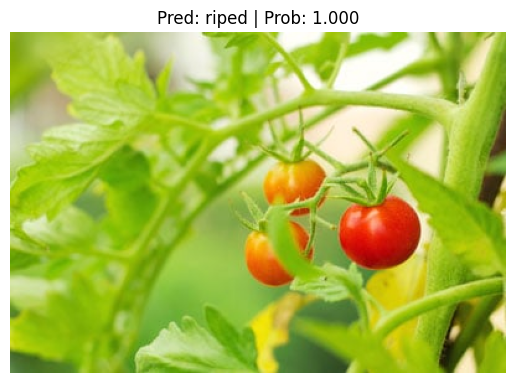

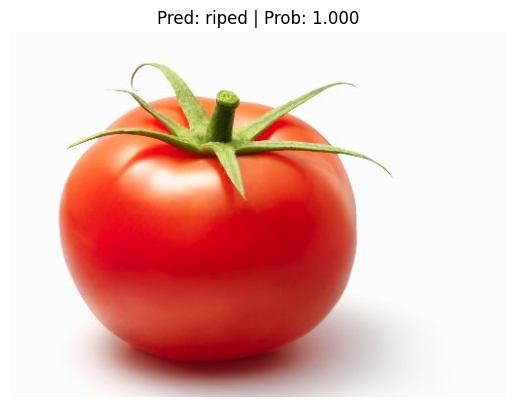

In [16]:
num_images_to_plot = 5

test_image_path_list = list(Path('/kaggle/working/data').glob("*/*.jpeg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        transform = transforms,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))